In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Ensamble de modelos y *random forest*

En un ensamble de modelos combinamos varios modelos para mejorar las predicciones (clasificación o regresión) de los modelos individuales.

Un grupo de modelos así se llama un **ensamble de modelos** y la técnica se llama *ensemble learning*.

Por ejemplo:

* Se puede entrenar un grupo de árboles de decisión, cada uno en un subconjunto aleatorio del conjunto de entrenamiento.
* Para realizar predicciones, obtenemos las predicciones de cada árbol y la predicción final es la clase que obtiene la mayoría de los votos.
* Este ensamble de modelos se llama un *random forest*.
* Aunque es un método simple, es uno de los algoritmos más poderosos de *machine learning*.

### Clasificadores con votos

| ![](figures_ensamble/fig7-1.png) |
|----------------------------------|
| Un grupo de clasificadores diversos. |

| ![](figures_ensamble/fig7-2.png) |
|----------------------------------|
| Clasificador por votos (*hard voting*) |

Un clasificador por votos a veces logra un *accuracy* mayor que el mejor clasificador del ensamble!

De hecho, incluso si cada clasificador es **débil** (es solo ligeramente mejor que adivinanzas al azar), el ensamble puede ser un clasificador **fuerte** (si hay muchos clasificadores y son muy diversos).

Por ejemplo: $1000$ clasificadores que son correctos 51% del tiempo. Usando la clase votado por la mayoría se puede esperar un rendimiento de 75%.

Este es verdad sólo si todos los clasificadores son independientes, y cometen errores sin correlaciones. Pero ya que están entrenados usando los mismos datos habrán correlaciones. Así que el rendimiento será un poco menor.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [5]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                          ('rf', rnd_clf), ('svc', svm_clf)],
                              voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


Si los clasificadores pueden dar la probabilidad para las clases (tienen un método `predict_proba()`) se puede predecir la clase con la mayor probabilidad, promediada sobre los clasificadores individuales. Este se llama *soft voting*.

Para implementar este, hay que usar `voting='soft'` en `VotingClassifier`, y todos los clasificadores tienen que tener un método de `predict_proba()`.

Por defecto SVC no tiene `predict_proba()`, pero se puede elegir la opción `True` para el hiperparámetro `probability` de ese modelo.

**Ejercicio**: implementar *soft voting* en el modelo arriba.

### *Bagging* y *pasting*

Otro método de tener un grupo de diverso de predictores es usar el mismo algoritmo para cada clasificador, pero usando distintos subconjuntos de entrenamiento.

* Si reemplazamos las instancias en el conjunto total cada vez que está elegida para un subconjunto (es decir, la misma instancia puede aparecer varias veces en el subconjunto) se llama *bagging* (*bootstrap aggregating*).
* Si **no** reemplazamos (cada instancia aparece solamente una vez en el subconjunto) se llama *pasting*.

![](figures_ensamble/fig7-4.png)

Con todos los predictores entrenados, agregamos las predicciones para llegar a la predicción del ensamble para una nueva instancia.

* Para clasificación la función de agregación es típicamente el **modo estadístico** (la predicción más frecuente).
* Para regresión es típicamente el promedio.

Ya que usamos subconjuntos de entrenamiento, el *bias* es mayor para cada predictor individual, pero la agregación reduce el *bias* y la varianza.

Es muy fácil parallelizar la operación de un ensamble.

##### Bagging/pasting en Scikit-Learn

En Scikit-Learn se puede usar *bagging/pasting* muy facilmente. El código abajo es para entrenar 500 clasificadores de árbol de decisión, con 100 instancias elegidas aleatoriamente del conjunto de entrenamiento para cada árbol.

La elección de las instancias es con reemplazo (*bagging*). Se puede cambiar a *pasting* con `bootstrap=False`.

También se puede usar un valor entre $0.0$ y $1.0$ para `max_samples`, y multiplicará el número total de instancias de entrenamiento por ese valor.

`n_jobs` es el número de núcleos (*cores*) de CPU usado. El valor `-1` indica que queremos usar todos los *cores* disponibles.

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, bootstrap=True, n_jobs=-1)

In [8]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

`BaggingClassifier` implementa *soft voting* automaticamente si el clasificador de base puede estimar probabilidades de las clases (tiene el método `predict_proba()`).

| ![](figures_ensamble/fig7-5.png) |
|----------------------------------|
| Árbol de decisión vs. ensamble de 500 árboles. |

El ensamble tiene un *bias* similar al árbol individual, pero hay menos varianza (comete el mismo número de errores en los datos de entrenamiento, pero el límite de decisión es menos irregular).

##### Evaluación *out-of-bag*

Con *bagging* es posible tener la misma instancia usada varias veces en el entrenamiento de un predictor, mientras para otro no está usada ni una vez.

![](figures_ensamble/fig_wiki_oob.jpg)

Por defect, `BaggingClassifier` toma $m$ instancias del conjunto de entrenamiento, con reemplazo (`bootstrap=True`), donde $m$ es el tamaño del conjunto.

$\sim 63$% de las instancias están usadas, en promedio, para cada predictor. Los demás $37$% se llaman instancias *out-of-bag* (oob).

Cada predictor tendrá un conjunto de instancias "oob" diferente.

Podemos usar las instancias "oob" para evaluación del modelo, en vez de usar un conjunto de validación, con `oob_score=True`.

In [32]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True)

In [33]:
bag_clf.oob_score_

0.896

Esperamos un *accuracy* de 90.1% en el conjunto de preuba...

In [34]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

También se puede obtener la función de decisión "oob" para cada instancia de entrenamiento.

En este caso el clasificador de base (`DecisionTreeClassifier`) tiene un método `predict_proba()`, así que la función de decisión retorna las probabilidades de cada clase para cada instancia de entrenamiento.

In [39]:
bag_clf.oob_decision_function_

array([[0.38586957, 0.61413043],
       [0.32571429, 0.67428571],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06818182, 0.93181818],
       [0.36507937, 0.63492063],
       [0.        , 1.        ],
       [0.98994975, 0.01005025],
       [0.97282609, 0.02717391],
       [0.79781421, 0.20218579],
       [0.01162791, 0.98837209],
       [0.79545455, 0.20454545],
       [0.78034682, 0.21965318],
       [0.96511628, 0.03488372],
       [0.05319149, 0.94680851],
       [0.        , 1.        ],
       [0.98192771, 0.01807229],
       [0.91397849, 0.08602151],
       [1.        , 0.        ],
       [0.03296703, 0.96703297],
       [0.31770833, 0.68229167],
       [0.89583333, 0.10416667],
       [1.        , 0.        ],
       [0.9704142 , 0.0295858 ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.63387978, 0.36612022],
       [0.

##### Parches aleatorios y sub-espacios aleatorios (random patches, random subspaces)

Se puede elegir los *features* usados en un `BaggingClassifier` aleatoriamente también. Hay dos hiperparámetros:

* `max_features`
* `bootstrap_features`

Estos son equivalentes a `max_samples` y `bootstrap` pero para los *features* en vez de las instancias.

Entonces, cada predictor está entrenado con un subconjunto aleatorio diferente de los *features*. Este es útil cuando los datos tienen muchas dimensiones.

* Parches aleatorios (*random patches*) corresponde a usar *bagging* para instancias y *features*
* Subespacios aleatorios (*random subspaces*) corresponde a usar todas las instancias de entrenamiento pero aplicar *bagging* a los *features* (`bootstrap=False`, `max_samples=1.0`, `bootstrap_features=True`, `max_features=x` donde `x < 1.0`)

Usando subconjuntos de *features* tenemos aún más diversidad de predictores, así que el *bias* aumenta y la varianza disminuye.

### Random Forests

Ya hemos usado un *random forest* (ensamble de árboles de decisión, usualmente ocupando *bagging* con `max_samples` igual al tamaño del conjunto de entrenamiento).

En vez de usar `BaggingClassifier` tenemos `RandomForestClassifier` que es más optimizado (también hay `RandomForestRegressor` para regresión).

In [40]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [41]:
y_pred_rf

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

En un *random forest* un nodo está dividido en cada árbol usando el mejor *feature* en un conjunto aleatorio de *features*.

Así que un *random forest* tiene más aleatoriedad que un árbol de decisión individual $\Rightarrow$ más *bias*, menos varianza.

#### Extra-Trees

Se puede usar umbrales aleatorios para cada *feature* en la división de los nodos, en vez de usar el mejor umbral posible (como lo que pasa con un árbol de decisión normal).

Un *random forest* así se llama un esamble de *extremely randomized trees* (*Extra-Trees*).

En Scikit-Learn está disponible con `ExtraTreesClassifier`.

Este modelo de nuevo aumenta el *bias* pero reduce la varianza.

#### Importancia de los *features*

Con un *random forest* se puede determinar la importancia relativa de cada *feature*.

La importancia de un *feature* está dada por cuanto está reducido la **impureza** (en promedio, sobre todos los árboles del bosque) por nodos que utilizan ese *feature*.

El promedio es un promedio ponderado, donde el peso de cada nodo es igual al número de instancias de entrenamiento asociado.

Scikit-Learn calcula esta importancia automaticamente para cada *feature* después del entrenamiento, y normaliza los resultados tal que $\sum_{i=0}^{n} I_i = 1$, donde $I_i$ es la importancia de *feature* $i$.

Se puede acceder a esta información con la variable `feature_importances_`.

##### Ejemplo con los dígitos de MNIST

In [42]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [43]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [44]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

[Text(1, 0.0, 'No importante'),
 Text(1, 0.009791489757332336, 'Muy importante')]

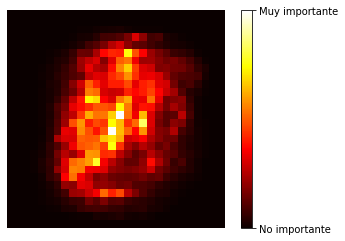

In [47]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['No importante', 'Muy importante'])

### Boosting